In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

Loading data below

In [2]:
with open('cifar-10-batches-py/test_batch', 'rb') as f:
    dict_ = pickle.load(f, encoding='latin1')
    data = dict_['data']
    labels = dict_['labels']
    required_indices = []
    for i in range(10):
        counter = 0
        inds = []
        j = 0
        while j < 3:
            if labels[counter] == i:
                inds.append(counter)
                j += 1
            counter += 1
        required_indices.append(inds)
    dat = np.zeros([30, 3, 32, 32])
    labs = []
    for i in range(10):
        for j in range(3):
            labs.append(i)
            dat[3*i+j, :, :, :] = np.array(data[required_indices[i][j]]).reshape([3, 32, 32])/255

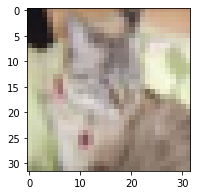

In [3]:
fig = plt.figure(figsize=[3,3])
plt.imshow(np.transpose(dat[10, :, :, :], (1,2,0)))
plt.show()

# Question 1
Below we first implement non-linearities.

In [4]:
def relu(img):
    return np.maximum(0,img)

def sigmoid(img):
    return 1/(1+np.exp(-img))

def tanh(img):
    return np.tanh(img)

def prelu(img, param):
    return np.maximum(img, 0) + param*np.minimum(0, img)

Below we implement the convolution function as required.

In [5]:
def convolution(img, kernel, stride, non_linearity, padding=0, prelu_param=None):
    K, _, _ = np.shape(kernel)
    padding = int(padding)
    C, H, W = np.shape(img)
    out_ = np.zeros([(H-K+2*padding)//stride + 1, (W-K+2*padding)//stride + 1])
    kernel = kernel[::-1, ::-1, :]

    horizontal_flip = img[:, :, ::-1]
    vertical_flip = img[:, ::-1, :]
    full_flip = img[:, ::-1, ::-1]
    padded_img = np.zeros([C, H+2*padding, W+2*padding])
    padded_img[:, padding:H+padding, padding:W+padding] = img #center
    padded_img[:, 0:padding, 0:padding] = full_flip[:, -padding:, -padding:] #top left corner
    padded_img[:, 0:padding, padding:W+padding] = vertical_flip[:, -padding:, :] #upper horizontal
    padded_img[:, padding:H+padding, 0:padding] = horizontal_flip[:, :, -padding:] #left vertical
    padded_img[:, -padding:, 0:padding] = full_flip[:, 0:padding, -padding:] #lower left corner
    padded_img[:, 0:padding, -padding:] = full_flip[:, -padding:, 0:padding] #upper right corner
    padded_img[:, -padding:, padding:W+padding] = vertical_flip[:, 0:padding, :] #lower horizontal
    padded_img[:, padding:H+padding, -padding:] = horizontal_flip[:, :, 0:padding] #right vertical
    padded_img[:, -padding:, -padding:] = full_flip[:, 0:padding, 0:padding] #lower right corner

    for m in range(out_.shape[0]):
        for n in range(out_.shape[1]):
            out_[m,n] = np.sum(padded_img[:, stride*m:stride*m+K, stride*n:stride*n+K]*np.transpose(kernel, (2,1,0)))
    if prelu_param is not None: return prelu(out_, prelu_param)
    return non_linearity(out_)

The convolution function has been tested below with stride = 2 and padding = 1. All 4 non-linearities have been tested in the order relu, sigmoid, tanh, prelu.

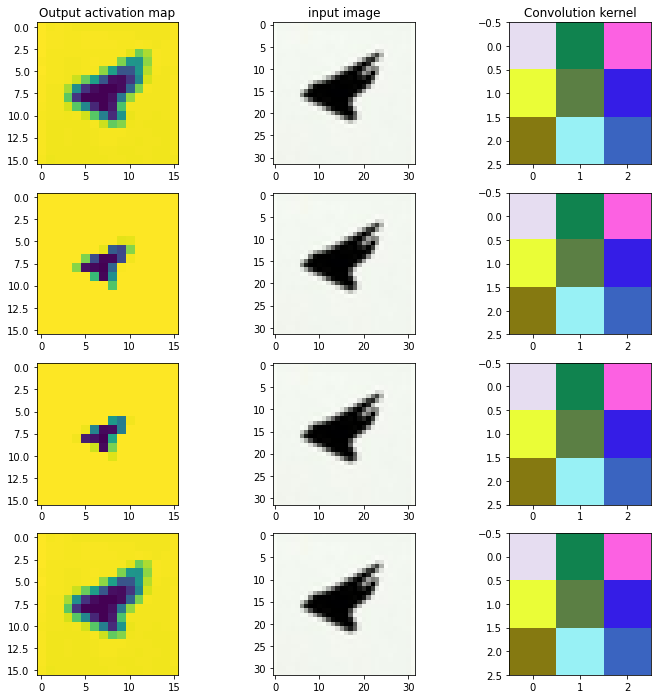

In [6]:
kern = np.random.uniform(0,1,[3, 3, 3])
a = convolution(dat[2, :, :, :], kern, 2, relu, 1)

fig, ax = plt.subplots(4,3, figsize=(12,12))
ax[0,0].imshow(a)
ax[0,0].set_title("Output activation map")

ax[0,1].imshow(np.transpose(dat[2, :, :, :], (1,2,0)))
ax[0,1].set_title("input image")

ax[0,2].imshow(kern)
ax[0,2].set_title("Convolution kernel")

a = convolution(dat[2, :, :, :], kern, 2, sigmoid, 1)
ax[1,0].imshow(a)
ax[1,1].imshow(np.transpose(dat[2, :, :, :], (1,2,0)))
ax[1,2].imshow(kern)

a = convolution(dat[2, :, :, :], kern, 2, tanh, 1)
ax[2,0].imshow(a)
ax[2,1].imshow(np.transpose(dat[2, :, :, :], (1,2,0)))
ax[2,2].imshow(kern)

a = convolution(dat[2, :, :, :], kern, 2, prelu, 1, 0.5)
ax[3,0].imshow(a)
ax[3,1].imshow(np.transpose(dat[2, :, :, :], (1,2,0)))
ax[3,2].imshow(kern)

plt.show()

# Question 2
Below we define the pool function and then define the pooling operations max_pool and avg_pool.

In [7]:
def pool(inp, pool_func, size, stride):
    H, W = np.shape(inp)
    out_ = np.zeros([(H-size)//stride+1, (W-size)//stride+1])
    for m in range(out_.shape[0]):
        for n in range(out_.shape[1]):
            out_[m, n] = pool_func(inp[stride*m:stride*m+size, stride*n:stride*n+size])
    return out_

def max_pool(inp):
    return np.max(inp)

def avg_pool(inp):
    return np.mean(inp)

Below we test the pool function with layer size of 3x3=1 and stride=1.

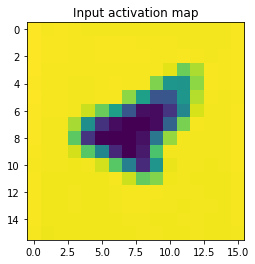

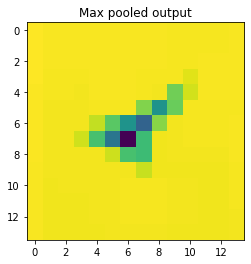

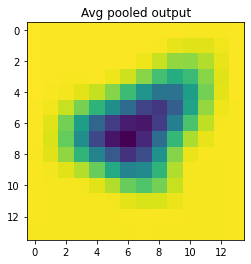

In [8]:
plt.imshow(a)
plt.title("Input activation map")
plt.show()

plt.imshow(pool(a, max_pool, 3, 1))
plt.title("Max pooled output")
plt.show()

plt.imshow(pool(a, avg_pool, 3, 1))
plt.title("Avg pooled output")
plt.show()

# Question 3
Below we implement convolution layer

In [9]:
def convolution_layer(img, kernels, stride, non_linearity, padding=0, prelu_param=None):
    out_channels, K, _, _ = kernels.shape
    padding = int(padding)
    C, H, W = np.shape(img)
    out_ = np.zeros([out_channels, (H-K+2*padding)//stride + 1, (W-K+2*padding)//stride + 1])
    for h in range(out_channels):
        out_[h, :, :] = convolution(img, kernels[h, :, :, :], stride, non_linearity, padding, prelu_param)
    return out_

Below we test the convolution_layer. The size of the output is n_kerns x W x H (10 x 32 x 32). Note that it is not W x H x C as throughout this assignment, I have used the more common NxCxHxW representation of images. Thus it is expected that we get 10x32x32 size for convolution layer output. Also H and W are 32 because in the below, I have used stride=1 and padding=1.

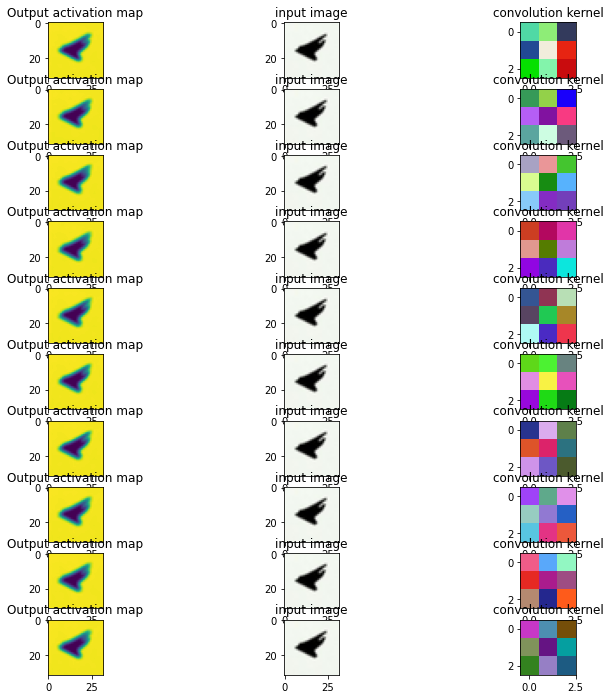

The expected shape of output is 10x32x32 as I have used NxCxHxW convention. The shape of output =  (10, 32, 32)


In [10]:
n_kerns = 10
kerns = np.random.uniform(0, 1, [n_kerns, 3, 3, 3])
a = convolution_layer(dat[2, :, :, :], kerns, 1, relu, 1)
fig, ax = plt.subplots(10, 3, figsize=(12,12))
for i in range(n_kerns):
    ax[i, 0].imshow(a[i, :, :])
    ax[i, 0].set_title("Output activation map")
    ax[i, 1].imshow(np.transpose(dat[2, :, :, :], (1,2,0)))
    ax[i, 1].set_title("input image")
    ax[i, 2].imshow(kerns[i, :, :, :])
    ax[i, 2].set_title("convolution kernel")

plt.show()
print("The expected shape of output is 10x32x32 as I have used NxCxHxW convention. The shape of output = ", np.shape(a))

# Question 4
Below we first implement pooling layer and then test it.

In [11]:
def pooling_layer(inp, pool_func, size, stride):
    C, H, W = np.shape(inp)
    out_ = np.zeros([C, (H-size)//stride+1, (W-size)//stride+1])
    for h in range(C):
        out_[h, :, :] = pool(inp[h, :, :], pool_func, size, stride)
    return out_

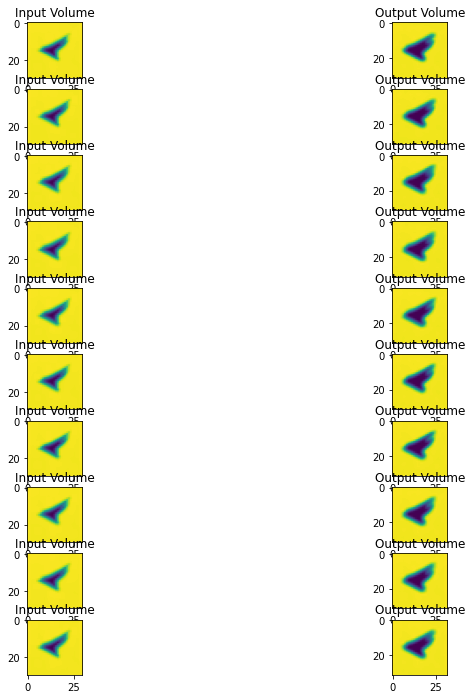

In [12]:
b = pooling_layer(a, max_pool, 3, 1)
fig, ax = plt.subplots(10, 2, figsize=(12,12))
for i in range(b.shape[0]):
    ax[i, 0].imshow(b[i, :, :])
    ax[i, 0].set_title("Input Volume")
    ax[i, 1].imshow(a[i, :, :])
    ax[i, 1].set_title("Output Volume")

plt.show()

# Question 5
Below we implement and test flatten layer as required.

In [13]:
class Flatten:
    def __init__(self, in_size, out_size):
        self.weights = np.random.uniform(-np.sqrt(6/(in_size+out_size)), np.sqrt(6/(in_size+out_size)), [in_size, out_size])

    def forward(self, x):
        x = x.flatten()
        return x@self.weights

In [14]:
print("Input shape:", b.shape)
layer = Flatten(np.prod(b.shape), 100)
print("Output shape:", layer.forward(b).shape)

Input shape: (10, 30, 30)
Output shape: (100,)


# Question 6
Below we implement a multi-layer perceptron. Then we test the model on appropriate input.

In [15]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

class Mlp:
    def __init__(self, in_size, hid_size, out_size):
        self.weights = []
        hid_size = [in_size]+hid_size+[out_size]
        for h in range(len(hid_size)-1):
            self.weights.append(np.random.uniform(-np.sqrt(6/(hid_size[h]+hid_size[h+1])), np.sqrt(6/(hid_size[h]+hid_size[h+1])), [hid_size[h], hid_size[h+1]]))

    def forward(self, x, non_linearity, softma=True):
        for h in range(len(self.weights)):
            x = non_linearity(x)@self.weights[h]
        if softma:
            x = softmax(x)
        return x

In [16]:
bottleneck_out = layer.forward(b)
mlp = Mlp(len(bottleneck_out), [20], 10)
with_softmax = mlp.forward(bottleneck_out, sigmoid)
without_softmax = mlp.forward(bottleneck_out, sigmoid, False)
print("Output with softmax: ", with_softmax)
print("Output without softmax", without_softmax)

Output with softmax:  [0.30528562 0.02559885 0.04864418 0.1542268  0.060962   0.05695303
 0.06565734 0.05813595 0.11816037 0.10637588]
Output without softmax [ 1.47703081 -1.00166972 -0.3596849   0.79420725 -0.13396621 -0.20199017
 -0.05976763 -0.18143272  0.52782579  0.42276185]


# Question 7
Below we implement the CNN model as required. The bottleneck layer has size 100. Hidden layer has size 50. $C_2$ is the number of output channels of first convolution layer. Thus $C_2 = 16$.

In [17]:
class CNN:
    def __init__(self, n_classes, in_size, hid_size):
        self.mlp = Mlp(in_size, hid_size, n_classes)
        self.flatten = Flatten(16*16*8, in_size)
        self.conv1_weights = np.random.uniform(-np.sqrt(6/(3+16)), np.sqrt(6/(3+16)), [16, 3, 3, 3])
        self.conv2_weights = np.random.uniform(-np.sqrt(6/(8+16)), np.sqrt(6/(8+16)), [8, 3, 3, 16])

    def forward(self, images, flat_out=False):
        out = []
        for h in range(images.shape[0]):
            out.append(convolution_layer(images[h, :, :, :], self.conv1_weights, 1, sigmoid, 1))
        for h in range(images.shape[0]):
            out[h] = pooling_layer(out[h], max_pool, 2, 2)
        for h in range(images.shape[0]):
            out[h] = convolution_layer(out[h], self.conv2_weights, 1, sigmoid, 1)
        for h in range(images.shape[0]):
            out[h] = self.flatten.forward(out[h])
        temp_ = np.array(out)
        for h in range(images.shape[0]):
            out[h] = self.mlp.forward(out[h], sigmoid)
        if flat_out:
            return np.array(out), temp_
        else: return np.array(out)

Below we test the CNN model with one sample.

In [18]:
model = CNN(10, 100, [50])
model.forward(dat[1:2])

array([[0.05958166, 0.06406984, 0.03293259, 0.19543744, 0.0638668 ,
        0.04347828, 0.05221634, 0.01704225, 0.36100503, 0.11036978]])

# Question 8
## Part A
Below we display the output vectors for sample from every class. The trend that I see is that all output vectors are really close to each other. This might be because of the small weights that I have initialized using the Xavier initialization scheme.

In [19]:
for e in range(10):
    print(model.forward(dat[3*e:3*e+1]))

[[0.05976817 0.06373114 0.03290836 0.19564289 0.06335862 0.04349644
  0.05227529 0.01700893 0.36083546 0.1109747 ]]
[[0.05986114 0.0649466  0.03313281 0.19242997 0.06374721 0.04308519
  0.0521326  0.01694691 0.36204203 0.11167553]]
[[0.05965579 0.0639436  0.03283788 0.19531333 0.06354514 0.04334392
  0.05200754 0.01704133 0.36081921 0.11149227]]
[[0.05980559 0.06406486 0.03306289 0.19469165 0.06358643 0.04329696
  0.05215324 0.01695021 0.36068652 0.11170165]]
[[0.05960485 0.06452055 0.03293212 0.19405987 0.06335354 0.04318421
  0.05245254 0.01690416 0.36193241 0.11105573]]
[[0.05972239 0.06453516 0.03297021 0.19276227 0.06360576 0.04305442
  0.05270095 0.01693395 0.36332447 0.11039043]]
[[0.05957243 0.06411235 0.03297817 0.19448334 0.06351449 0.04313048
  0.05233163 0.016905   0.36244363 0.11052848]]
[[0.05999936 0.06481365 0.03319633 0.19071757 0.06361546 0.04302867
  0.05259856 0.01716147 0.36370697 0.11116196]]
[[0.05953323 0.06404542 0.03278022 0.19545213 0.06383957 0.043682
  0.05

# Part B
Below we visualize the output from the flattening layer using tSNE plot. In my experiments, I did not observe the model showing any discriminability.

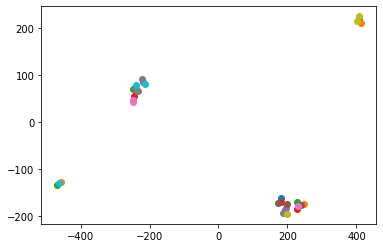

In [20]:
from sklearn.manifold import TSNE
result, flt_out = model.forward(dat, True)
a = TSNE(n_components=2, init='random', perplexity=0.1, n_iter=5000).fit_transform(flt_out)
for i in range(10):
    plt.scatter(a[3*i:3*i+3, 0], a[3*i:3*i+3, 1], marker='o')
plt.show()